In [38]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [39]:
def rhumb_dist(lat1,long1,lat2,long2):
        lat1 = np.radians(lat1)
        long1 = np.radians(long1)
        lat2 = np.radians(lat2)
        long2 = np.radians(long2)
        
        R = 6371.
        d_proj_lat = np.log(np.tan(np.pi/4 + lat2/2) / np.tan(
                np.pi/4 + lat1/2))
        
        d_lat = np.abs(lat2 - lat1)
        d_long = np.abs(long2 - long1)
        
        if np.abs(d_proj_lat) > 0.0000000000001:
                q = d_lat/d_proj_lat
        else:
                q = np.cos(lat1)
        
        if (np.abs(d_long) > np.pi):
                if d_long > 0:
                        d_long = -(2*np.pi-d_long)
                else:
                        d_long = (2*np.pi+d_long)
        
        dist = np.sqrt(d_lat * d_lat + q * q * d_long * d_long) * R
        return dist * 1000

def rhumb_course(lat1,long1,lat2,long2):
        
        lat1 = np.radians(lat1)
        long1 = np.radians(long1)
        lat2 = np.radians(lat2)
        long2 = np.radians(long2)
        d_proj_lat = np.log(np.tan(np.pi/4 + lat2/2) / np.tan(
                np.pi/4 + lat1/2))
        
        d_long = (long2-long1)
        
        if (np.abs(d_long) > np.pi):
                if d_long >0:
                        d_long = -(2*np.pi-d_long)
                else:
                        d_long = (2*np.pi+d_long)
        
        c = np.arctan2(d_long,d_proj_lat)
        return (np.degrees(c) + 360) % 360


In [40]:
df = pd.DataFrame()

tree = ET.parse('../2020/peter.xml')

root = tree.getroot()

In [41]:
for trk in root.findall('{http://www.topografix.com/GPX/1/1}trk'):
        pass

trkseg = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')

trkpts = trkseg[0].findall('{http://www.topografix.com/GPX/1/1}trkpt')

i = 0
for trkpt in trkpts:

        pos = trkpt.attrib
        df.at[i,'lat'] = pos['lat']
        df.at[i,'lon'] = pos['lon']
        
        for  item in trkpt:
                
                tag = item.tag.split('}')[1]
                df.at[i,tag] = item.text
                
                ext =item.findall(
                        '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension')
                
                for e in ext:
                        
                        df.at[i,'temp'] = e[0].text
                        df.at[i,'hr'] = e[1].text
                        df.at[i,'cad'] = e[2].text
        
        i += 1



In [42]:
sub = 10
df = df[::sub]

In [43]:
### seems that on notebook this has to be commented out after first run
df.drop('extensions',axis=1,inplace=True)

In [44]:


df[['lat','lon','ele','temp']] = df[['lat','lon','ele','temp']].astype(float)
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.tz_localize(None)
df[['hr','cad']] = df[['hr','cad']].astype(int)
df['hrdelta'] = df['hr'] - df['hr'].shift()



df['dist'] = np.vectorize(rhumb_dist)(
        df['lat'],df['lon'],df['lat'].shift(),df['lon'].shift())

df['timedelta'] = df['time'] - df['time'].shift()
df['timedelta'] = df['timedelta'].dt.total_seconds()
df['speed'] = df['dist'] / df['timedelta']
df['km/h'] = df['speed'] * 3.6
df['eledelta'] = df['ele'] - df['ele'].shift()
df['slope%'] = (df['eledelta'] / df['dist']) * 100
df['cumsec'] = df['timedelta'].cumsum()
df['cumdist'] = df['dist'].cumsum()

mask = df['speed'] < 20 # remove anomalies
df = df[mask]

cols = ['time','timedelta','cumsec','dist',
        'cumdist','ele','eledelta','slope%','speed',
        'km/h','hr','hrdelta','cad','temp','lat','lon']

df = df[cols]

print (df.head(40))
print (df.describe())
print (df.sum())


                   time  timedelta  cumsec        dist      cumdist  \
10  2020-01-26 07:09:57       28.0    28.0  111.226399   111.226399   
20  2020-01-26 07:10:21       24.0    52.0  107.508079   218.734478   
30  2020-01-26 07:10:54       33.0    85.0  125.570593   344.305071   
40  2020-01-26 07:11:23       29.0   114.0   34.192155   378.497226   
50  2020-01-26 07:11:55       32.0   146.0   30.852591   409.349818   
60  2020-01-26 07:12:23       28.0   174.0   34.581342   443.931160   
70  2020-01-26 07:12:56       33.0   207.0   50.476375   494.407535   
80  2020-01-26 07:13:39       43.0   250.0  110.611191   605.018727   
90  2020-01-26 07:14:15       36.0   286.0   53.059944   658.078671   
100 2020-01-26 07:15:00       45.0   331.0  120.209567   778.288238   
110 2020-01-26 07:15:44       44.0   375.0  168.739919   947.028157   
120 2020-01-26 07:16:17       33.0   408.0  151.855656  1098.883813   
130 2020-01-26 07:16:45       28.0   436.0  148.645421  1247.529233   
140 20

In [45]:
def regression(x,y,alpha,beta,sigma):
    
    @pm.deterministic()
    def linreq(x=x,alpha=alpha,beta=beta):
        return x * beta + alpha

    likelihood = pm.Normal('likelihood',
                           mu=linreq,
                           tau = 1 / sigma ** 2,
                           observed=True,
                           value=y)

    model = pm.Model([alpha,beta,sigma,linreq,likelihood])
    map_ = pm.MAP(model)
    map_.fit()

    mcmc = pm.MCMC(model)
    mcmc.sample(10000 ,5000 ,2)

    alpha_posterior = mcmc.trace('alpha')[:]
    beta_posterior = mcmc.trace('beta')[:]
    sigma_posterior = mcmc.trace('sigma')[:]
    linreq_posterior = mcmc.trace('linreq')[:,0]

    results = pd.DataFrame({'alpha_posterior':alpha_posterior,
                            'beta_posterior':beta_posterior,
                            'sigma_posterior':sigma_posterior,
                            'linreq_posterior':linreq_posterior})

    return results


In [46]:
def create_filename(title):
        words = title.split()
        filename = '_'.join(words) + '.jpg'
        return filename

In [47]:
def plot_regression(x,y,result,title,xlabel,ylabel):
        
        ###
        nr_samples = 3000
        ###

        rows = np.random.choice(range(len(result)),
                                replace=True,size=nr_samples)

        alphas = result['alpha_posterior'][rows]
        betas = result['beta_posterior'][rows]

        X = np.linspace(x.min(),x.max(),len(rows))

        lines = np.array([X[i] * betas + alphas for i in range(len(X))])

        # simulated_yvals are generated as normally distributed y-values
        # based on the posterior alphas & betas, that is,
        # each simulated yval is built by the linreg function, by the
        # posterior alphas and betas.
        # Used for fill_between.

        simulated_yvals = np.array(
                [np.random.normal(
                        X[i] * result['beta_posterior'] + result['alpha_posterior'],
                        result['sigma_posterior']) for i in range(len(X))])

        low,high = np.percentile(simulated_yvals,[5.5,94.5],axis=1)
        # for each x value, get the high & low y value in the 89% interval

        plt.figure(figsize=(18,12))
        plt.plot(X,lines,alpha=0.01,color='r')
        #plt.plot(X,slope * X + intercept,color='k',ls='dashed')
    
        plt.fill_between(np.linspace(min(x),max(x),high.size),
                         low,high,color='c',alpha=0.4)


        plt.scatter(x,y)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

        filename = create_filename(title)

        plt.savefig(filename,format='jpg')
        

In [48]:
def plot_histogram(param,title,xlabel,ylabel):
        plt.figure(figsize=(18,12))
        plt.hist(param,density=True,bins=20)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        filename = create_filename(title)
        plt.savefig(filename,format='jpg')


 [-----------------100%-----------------] 10000 of 10000 complete in 17.9 sec    alpha_posterior  beta_posterior  sigma_posterior  linreq_posterior
0        146.577765        4.663052         5.949889        141.895189
1        146.827571        4.663052         5.949889        142.144995
2        146.827571        4.663052         5.949889        142.144995
3        146.827571        4.663052         5.949889        142.144995
4        146.827571        4.285607         5.949889        142.524021
5        146.827571        4.285607         5.949889        142.524021
6        146.827571        4.285607         5.949889        142.524021
7        146.827571        4.285607         5.949889        142.524021
8        146.827571        4.285607         5.949889        142.524021
9        146.827571        4.285607         5.949889        142.524021
10       146.827571        4.285607         5.949889        142.524021
11       146.827571        4.285607         5.949889        142.524021


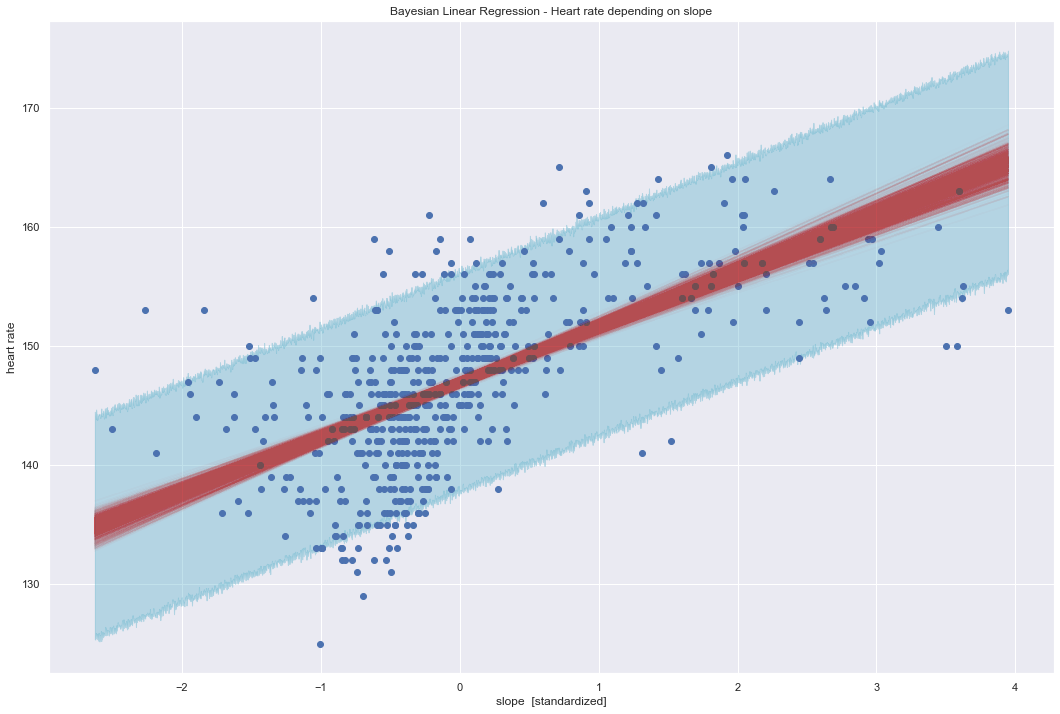

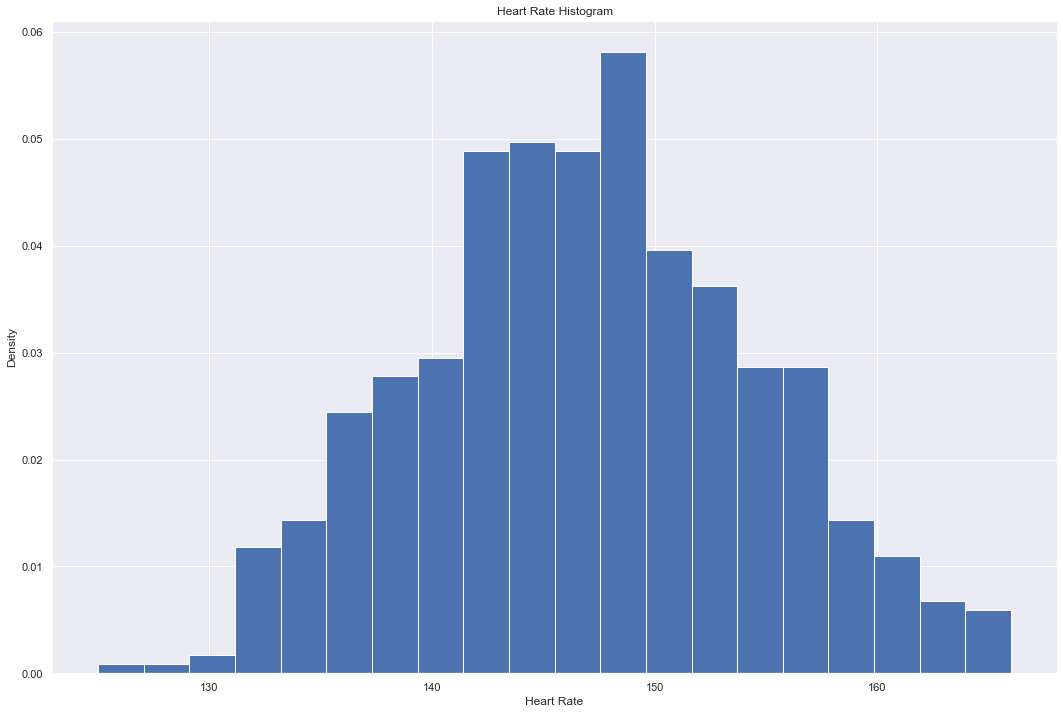

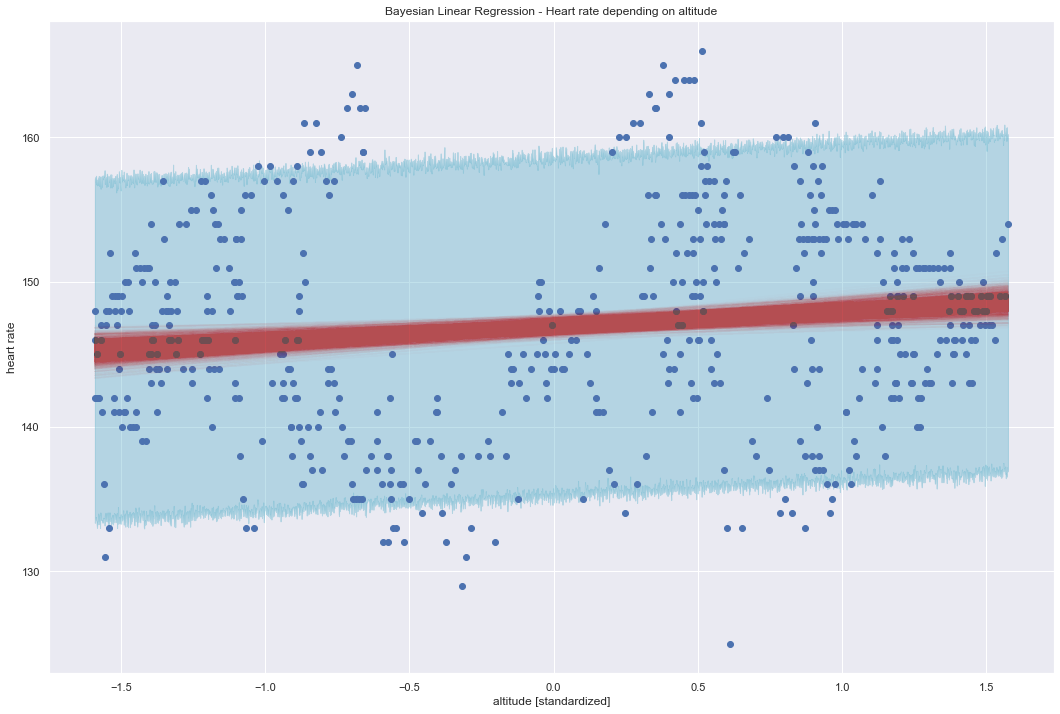

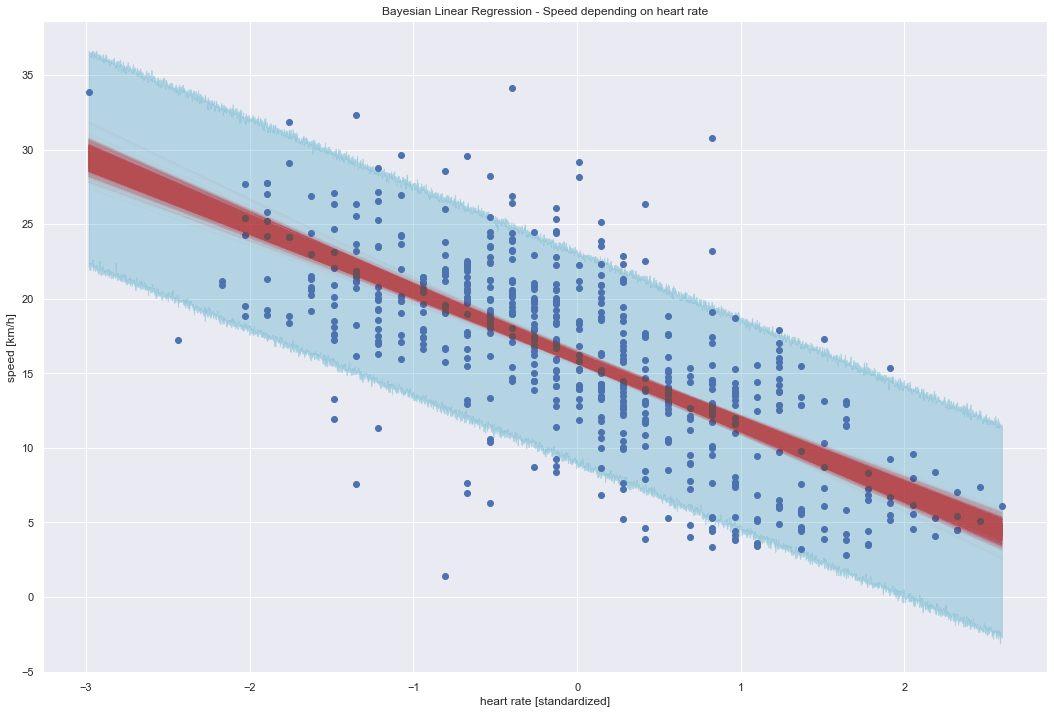

In [49]:
timebins = [0,3600,7200,10800,14400,18000]
timebin_labels = ['1:st hour','2:d hour','3:d hour','4:th hour','5:th hour']

df['timebins'] = pd.cut(df['cumsec'],bins=timebins,labels=timebin_labels)

df.to_pickle('marcia_longa_analys.pkl')

x = (df['slope%'] - df['slope%'].mean()) / df['slope%'].std()
y = df['hr']

# need a df to joint sort
slope_hr_df = pd.DataFrame({'hr':y,'slope%':x})
slope_hr_df.sort_values('hr',inplace=True)

alpha_sigma = 10 
beta_sigma = 5
sigma = pm.Uniform('sigma',lower=0,upper=10)
alpha = pm.Normal('alpha',mu=150,tau=1/alpha_sigma ** 2) # mu ~ hr at mean slope
beta = pm.Normal('beta',mu=10,tau=1/beta_sigma ** 2)

result = regression(slope_hr_df['slope%'],slope_hr_df['hr'],alpha,beta,sigma)

print (result.head(40))
print (result.describe())

plot_regression(slope_hr_df['slope%'],
                slope_hr_df['hr'],result,
                'Bayesian Linear Regression - Heart rate depending on slope',
                'slope  [standardized]',
                'heart rate')

plot_histogram(slope_hr_df['hr'],
               'Heart Rate Histogram',
               'Heart Rate',
               'Density')


x = (df['ele'] - df.ele.mean()) / df.ele.std()
y = df.hr

ele_hr_df = pd.DataFrame({'ele':x,'hr':y})

alpha_sigma = 100
beta_sigma = 10
alpha = pm.Normal('alpha',mu=1000,tau=1/alpha_sigma ** 2)
beta = pm.Normal('beta',mu=0,tau=1/beta_sigma ** 2)
sigma = pm.Uniform('sigma',lower=0,upper=10)

result = regression(ele_hr_df['ele'],ele_hr_df['hr'],alpha,beta,sigma)

plot_regression(ele_hr_df['ele'],
                ele_hr_df['hr'],
                result,
                'Bayesian Linear Regression - Heart rate depending on altitude',
                'altitude [standardized]',
                'heart rate')


x = (df.hr - df.hr.mean()) / df.hr.std()
y = df['km/h']

hr_speed_df = pd.DataFrame({'hr': x,'km/h':y})

alpha_sigma = 5
beta_sigma = 10
alpha = pm.Normal('alpha',mu=20,tau=1/alpha_sigma ** 2)
beta = pm.Normal('beta',mu=0,tau=1/beta_sigma ** 2)
sigma = pm.Uniform('sigma',lower=0,upper=10)

result = regression(hr_speed_df['hr'],hr_speed_df['km/h'],alpha,beta,sigma)

plot_regression(hr_speed_df['hr'],
                    hr_speed_df['km/h'],
                    result,
                    'Bayesian Linear Regression - Speed depending on heart rate',
                    'heart rate [standardized]',
                    'speed [km/h]')


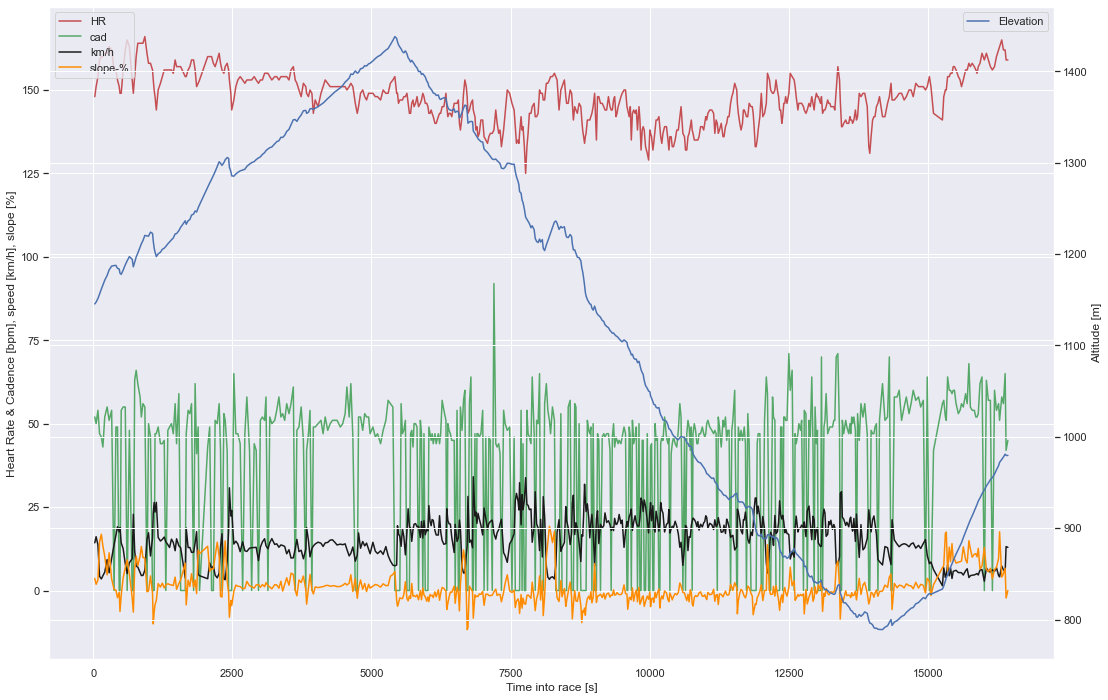

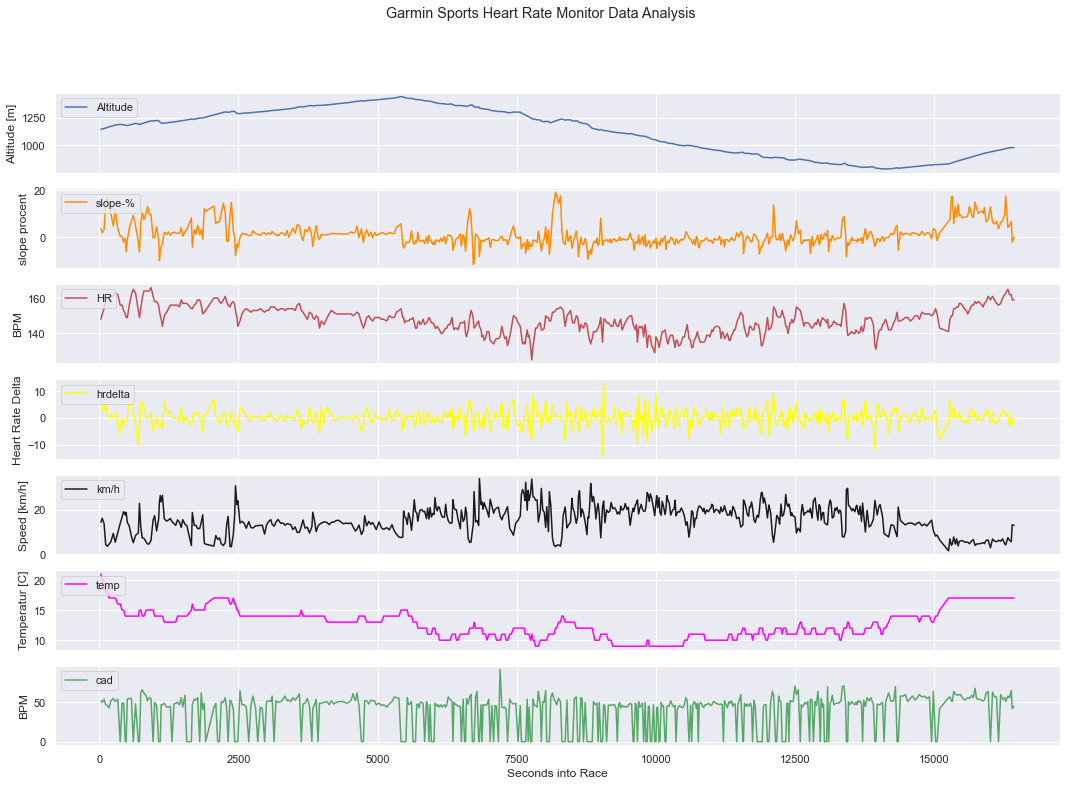

In [50]:
plt.figure(figsize=(18,12))
ax = plt.gca()
ax.plot(df['cumsec'],df['hr'],color='r',label='HR')
ax.plot(df['cumsec'],df['cad'],color='g',label='cad')
ax.plot(df['cumsec'],df['km/h'],color='k',label='km/h')
ax.plot(df['cumsec'],df['slope%'],color='darkorange',label='slope-%')
ax.legend(loc='upper left')
ax.set_xlabel('Time into race [s]')
ax.set_ylabel('Heart Rate & Cadence [bpm], speed [km/h], slope [%]')
ax2 = plt.twinx()
ax2.plot(df['cumsec'],df['ele'],color='b',label='Elevation')
ax2.legend(loc='upper right')
ax2.set_ylabel('Altitude [m]')

fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(
        7,1,sharex=True,
        figsize=(18,12))

fig.suptitle('Garmin Sports Heart Rate Monitor Data Analysis')

ax1.plot(df['cumsec'],df['ele'],color='b',label='Altitude')
ax1.set_ylabel('Altitude [m]')
ax1.legend(loc='upper left')
ax2.plot(df['cumsec'],df['slope%'],color='darkorange',label='slope-%')
ax2.set_ylabel('slope procent')
ax2.legend(loc='upper left')
ax3.plot(df['cumsec'],df['hr'],color='r',label='HR')
ax3.set_ylabel('BPM')
ax3.legend(loc='upper left')
ax4.plot(df['cumsec'],df['hrdelta'],color='yellow',label='hrdelta')
ax4.set_ylabel('Heart Rate Delta')
ax4.legend(loc='upper left')
ax5.plot(df['cumsec'],df['km/h'],color='k',label='km/h')
ax5.set_ylabel('Speed [km/h]')
ax5.legend(loc='upper left')
ax6.plot(df['cumsec'],df['temp'],color='magenta',label='temp')
ax6.legend(loc='upper left')
ax6.set_ylabel('Temperatur [C]')
ax7.plot(df['cumsec'],df['cad'],color='g',label='cad')
ax7.set_ylabel('BPM')
ax7.legend(loc='upper left')
ax7.set_xlabel('Seconds into Race')

plt.savefig('Peter_marcia_analys.jpg',format='jpg')


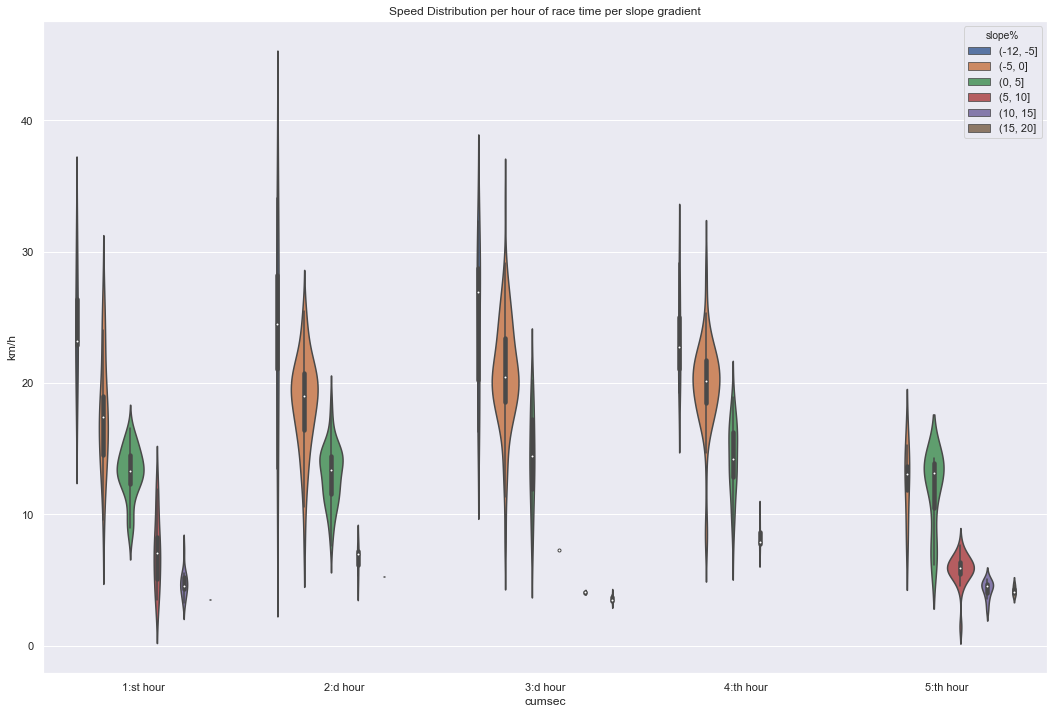

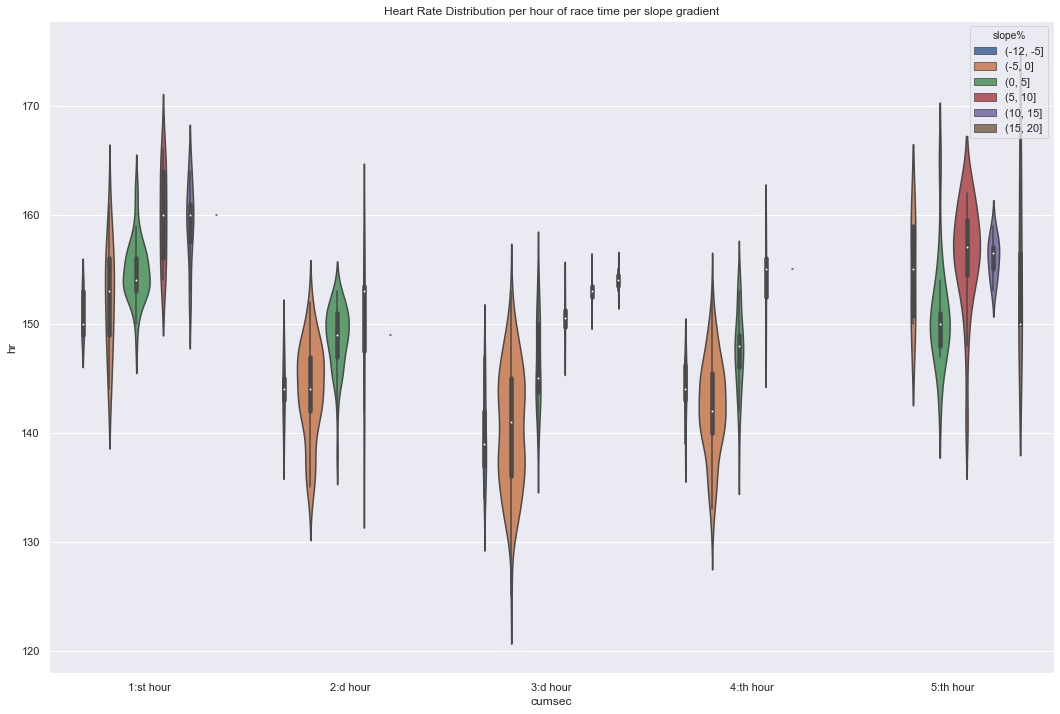

In [51]:
slopebins = [ -12,-5,0,5,10,15,20]
hue = pd.cut(df['slope%'],bins=slopebins)

plt.figure(figsize=(18,12))
title = 'Speed Distribution per hour of race time per slope gradient'
xlabel = 'Seconds into race'
ylabel = 'Speed [km/h]'

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

sns.violinplot(x=pd.cut(
        df['cumsec'],bins=timebins,
        labels=timebin_labels),y='km/h',data=df,
               inner='box',scale='count',hue=hue)

filename = create_filename(title)
plt.savefig(filename,format='jpg')

plt.figure(figsize=(18,12))
title = 'Heart Rate Distribution per hour of race time per slope gradient'
xlabel = 'Seconds into race'
ylabel = 'Heart Rate [bpm]'

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

sns.violinplot(x=pd.cut(
        df['cumsec'],bins=timebins,
        labels=timebin_labels),y='hr',data=df,
               inner='box',scale='count',hue=hue)

filename = create_filename(title)
plt.savefig(filename,format='jpg')
plt.show()
